In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pycountry
from countryinfo import CountryInfo as CInfo # Se conecta con la informacion de cada país
import matplotlib.pyplot as plt
import  altair  as  alt # Graficos de promedios
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
url = "https://raw.githubusercontent.com/github/innovationgraph/main/data/languages.csv"
data = pd.read_csv(url, delimiter=',', keep_default_na=False)
data.head()

,num_pushers,language,language_type,iso2_code,year,quarter
0,2066,HTML,markup,AE,2020,1
1,1627,CSS,markup,AE,2020,1
2,288,Jupyter Notebook,markup,AE,2020,1
3,108,Vue,markup,AE,2020,1
4,1734,JavaScript,programming,AE,2020,1


In [76]:
# Filtro de EU
data = data[data.iso2_code != "EU"]

# Filtro de XK = Kosovo
data = data[data.iso2_code != "XK"]

In [77]:
nan_rows_count = data.isna().any(axis=1).sum()
print(f"There are {nan_rows_count} rows with NaN values in the dataset.")

There are 0 rows with NaN values in the dataset.


In [78]:
# Seleccionamos los 10 lenguajes mas usados en Data Science
top_program_lang = programming_languages = [
    "Python", "Java",
    "C++", "C","JavaScript", "C#",
    "Ruby", "Go", "PHP", "TypeScript"
]

In [79]:
data2 = data[data['language'].isin(top_program_lang)]
data2 = data2.reset_index(drop=True)
data2.head()

,num_pushers,language,language_type,iso2_code,year,quarter
0,1734,JavaScript,programming,AE,2020,1
1,816,Python,programming,AE,2020,1
2,685,Java,programming,AE,2020,1
3,377,Ruby,programming,AE,2020,1
4,354,PHP,programming,AE,2020,1


In [80]:
data2['year_quarter'] = data2['year'].astype(str) + '-Q' + data2['quarter'].astype(str)
data2
# Reseteamos el index
data2 = data2.reset_index(drop=True)
data2.head()

,num_pushers,language,language_type,iso2_code,year,quarter,year_quarter
0,1734,JavaScript,programming,AE,2020,1,2020-Q1
1,816,Python,programming,AE,2020,1,2020-Q1
2,685,Java,programming,AE,2020,1,2020-Q1
3,377,Ruby,programming,AE,2020,1,2020-Q1
4,354,PHP,programming,AE,2020,1,2020-Q1


In [81]:
# Creating a unique identifier
data2['unique_id'] = data2['iso2_code'] + '-' + data2['language']

In [82]:
# Create a DataFrame of unique identifiers
iso2_code = pd.DataFrame({'iso2_code': data2['iso2_code'].unique()})

# Create a DataFrame of unique identifiers for languages 
language = pd.DataFrame({'language': data2['language'].unique()})

# Create a DataFrame of all time periods
# time_periods = pd.DataFrame({'year_quarter': range(data2['year_quarter'].min(), data2['year_quarter'].max() + 1)})
year_quarter = pd.DataFrame({'year_quarter': data2['year_quarter'].unique()})

# Create the Cartesian product of unique_ids and time_periods
balanced_panel = iso2_code.merge(language, how='cross').merge(year_quarter, how='cross')

balanced_panel["unique_id"] = balanced_panel["iso2_code"] + "-" +balanced_panel["language"]
balanced_panel

# # Merge the balanced panel with the original data
balanced_df = balanced_panel.merge(data2, on=['unique_id', 'year_quarter'], how='left')

# # Merge the DataFrames with suffixes
balanced_df = balanced_panel.merge(data2, on=['unique_id', 'year_quarter'], how='left', suffixes=('', '_y'))

# # Now, drop the columns with '_y' suffix, which are from the right DataFrame
balanced_df = balanced_df.loc[:, ~balanced_df.columns.str.endswith('_y')]
balanced_df.head()

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter
0,AE,JavaScript,2020-Q1,AE-JavaScript,1734.0,programming,2020.0,1.0
1,AE,JavaScript,2020-Q2,AE-JavaScript,2299.0,programming,2020.0,2.0
2,AE,JavaScript,2020-Q3,AE-JavaScript,2366.0,programming,2020.0,3.0
3,AE,JavaScript,2020-Q4,AE-JavaScript,2468.0,programming,2020.0,4.0
4,AE,JavaScript,2021-Q1,AE-JavaScript,2544.0,programming,2021.0,1.0


In [83]:
# Function to convert quarter format to integer
def quarter_to_int(quarter_string):
    year, q = quarter_string.split('-')
    year = int(year)
    quarter_number = int(q[1])  # Q1, Q2, Q3, Q4 -> 1, 2, 3, 4
    base_year = 2020  # Adjust based on your balanced_df, or set dynamically
    return 4 * (year - base_year) + quarter_number

# Applying the function
balanced_df['quarter'] = balanced_df['year_quarter'].apply(quarter_to_int)
balanced_df['year'] = balanced_df['year_quarter'].str.split('-').str[0]
balanced_df.loc[balanced_df["num_pushers"].isnull(), "num_pushers"] = 0
balanced_df.head()

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter
0,AE,JavaScript,2020-Q1,AE-JavaScript,1734.0,programming,2020,1
1,AE,JavaScript,2020-Q2,AE-JavaScript,2299.0,programming,2020,2
2,AE,JavaScript,2020-Q3,AE-JavaScript,2366.0,programming,2020,3
3,AE,JavaScript,2020-Q4,AE-JavaScript,2468.0,programming,2020,4
4,AE,JavaScript,2021-Q1,AE-JavaScript,2544.0,programming,2021,5


## Per capita measures

In [84]:
# Definimos una función que convierte los nombres de países en códigos iso2
def country_to_iso2(country_name):
    try:
        # Intentamos obtener el código iso2 del país usando pycountry
        return pycountry.countries.get(name=country_name).alpha_2
    except AttributeError:
        try:
            # Manejamos casos especiales donde el nombre del país no coincide exactamente con la base de datos de pycountry
            special_cases = {
                "Czechia (Czech Republic)": "CZ",
                "Congo (Congo-Brazzaville)": "CG",
                "Holy See": "VA",
                "Timor-Leste (East Timor)": "TL",
                "Ukraine (with certain exceptions)": "UA",
                "Taiwan": "TW",
                "Bolivia": "BO",
                "Tanzania": "TZ",
                "South Korea": "KR",
                "Moldova": "MD",
                "Brunei": "BN"
            }
            return special_cases[country_name]
        except KeyError:
            return None

# Creamos una lista de países y obtenemos sus códigos iso2 usando la función country_to_iso2
gpt_countries_list = [
    "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia", "Austria",
    "Azerbaijan", "Bahamas", "Bangladesh", "Barbados", "Belgium", "Belize", "Benin", "Bhutan", "Bolivia",
    "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Cabo Verde", "Canada",
    "Chile", "Colombia", "Comoros", "Congo (Congo-Brazzaville)", "Costa Rica", "Côte d'Ivoire", "Croatia", "Cyprus",
    "Czechia", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Estonia", "Fiji",
    "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea",
    "Guinea-Bissau", "Guyana", "Haiti", "Holy See", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iraq",
    "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kuwait",
    "Kyrgyzstan", "Latvia", "Lebanon", "Lesotho", "Liberia", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar",
    "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico",
    "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
    "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia", "Norway",
    "Oman", "Pakistan", "Palau", "Palestine, State of", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines",
    "Poland", "Portugal", "Qatar", "Romania", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia",
    "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal",
    "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "South Africa",
    "South Korea", "Spain", "Sri Lanka", "Suriname", "Sweden", "Switzerland", "Taiwan", "Tanzania", "Thailand",
    "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Tuvalu", "Uganda", "Ukraine",
    "United Arab Emirates", "United Kingdom", "United States", "Uruguay", "Vanuatu", "Zambia"
]

gpt_countries_iso = [country_to_iso2(country) for country in gpt_countries_list]

# Agregamos una nueva columna gpt_available, con valor 1 si el código iso2 está en la lista gpt_countries_iso, y 0 en caso contrario
balanced_df["gpt_available"] = balanced_df["iso2_code"].apply(lambda row: 1 if row in gpt_countries_iso else 0)

In [85]:
countries = balanced_df.iso2_code.unique()

def create_populations_dictionary():
    country_populations = {}
    special_cases = {"MM": 54688774, "PS": 5483450, "ME": 602445, "AD":79824}
    # special_cases = {}
    for country in countries:
        try:
            country_populations.update({country: CInfo(country).info()["population"]})
        except KeyError:
            try:
                fallback_name = pycountry.countries.lookup(country).name
                country_populations.update({country: CInfo(fallback_name).info()["population"]})
            except KeyError:
                print(country)
                country_populations.update({country: special_cases[country]})

    return country_populations

country_populations = create_populations_dictionary()

ME
MM
PS
AD


In [86]:
# Create population
balanced_df["population"] = balanced_df["iso2_code"].map(country_populations)

# Create pushes_pc
balanced_df["num_pushers_pc"] = (balanced_df["num_pushers"] / balanced_df["population"])*100000

# **Figure 1:**  Pushers per 100k 

BANGLADESH

In [87]:
# balanced_df[balanced_df['iso2_code'] == 'IN']

In [88]:
df_filtered_BD = balanced_df[balanced_df['iso2_code'] == 'BD']

In [89]:
df_filtered_BD.head()

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter,gpt_available,population,num_pushers_pc
1530,BD,JavaScript,2020-Q1,BD-JavaScript,7039.0,programming,2020,1,1,157486000,4.469604
1531,BD,JavaScript,2020-Q2,BD-JavaScript,8393.0,programming,2020,2,1,157486000,5.329363
1532,BD,JavaScript,2020-Q3,BD-JavaScript,11229.0,programming,2020,3,1,157486000,7.130158
1533,BD,JavaScript,2020-Q4,BD-JavaScript,11331.0,programming,2020,4,1,157486000,7.194925
1534,BD,JavaScript,2021-Q1,BD-JavaScript,14077.0,programming,2021,5,1,157486000,8.938572


In [90]:
# Suponiendo que 'data' es tu DataFrame
data_aggregated_BD = df_filtered_BD.groupby('language').size().reset_index(name='counts')
data_aggregated_BD['percentage'] = (data_aggregated_BD['counts'] / data_aggregated_BD['counts'].sum()) * 100

In [91]:
# Convertir 'num_pushers' a numérico si es necesario
df_filtered_BD['num_pushers_pc'] = pd.to_numeric(df_filtered_BD['num_pushers_pc'], errors='coerce')

# Agregar datos por 'year_quarter' y 'language'
data_aggregated_BD = df_filtered_BD.groupby(['year_quarter', 'language'], as_index=False).agg(
    total_pushers=('num_pushers_pc', 'sum')
).rename(columns={'total_pushers': 'num_pushers_pc'})

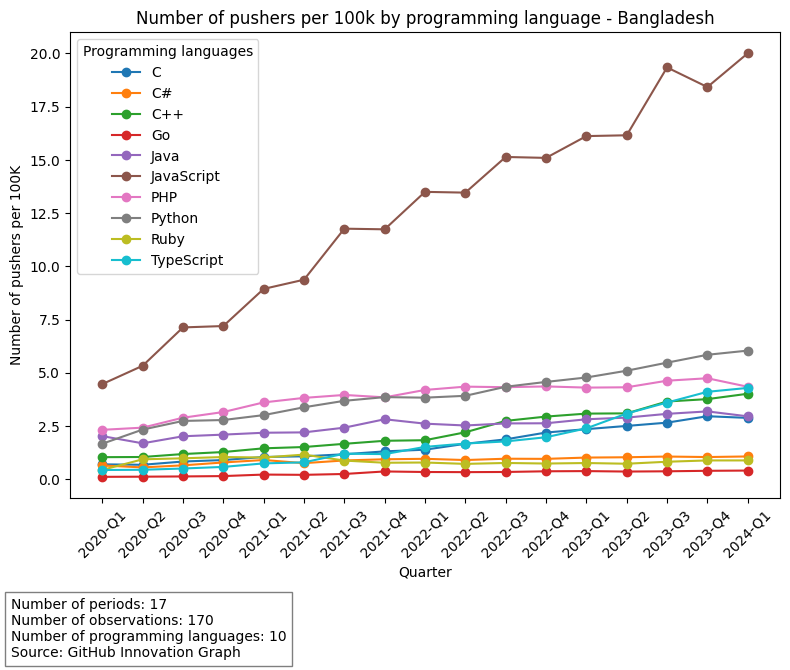

In [127]:
# Crear el gráfico de líneas
plt.figure(figsize=(8, 6))

for language in data_aggregated_BD['language'].unique():
    language_data = data_aggregated_BD[data_aggregated_BD['language'] == language]
    plt.plot(language_data['year_quarter'], language_data['num_pushers_pc'], marker='o', label=language)

# Personalizar el gráfico
plt.title('Number of pushers per 100k by programming language - Bangladesh')
plt.xlabel('Quarter')
plt.ylabel('Number of pushers per 100K')
plt.legend(title='Programming languages')
plt.xticks(rotation=45)

# Crear el texto de las estadísticas
statistics_text = ('Number of periods: 17\n'
                   'Number of observations: 170\n'
                   'Number of programming languages: 10\n'
                   'Source: GitHub Innovation Graph')

# Añadir texto adicional debajo del gráfico
plt.figtext(0.02, -0.1, statistics_text, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

SRI LANKA

In [93]:
df_filtered_LK = balanced_df[balanced_df['iso2_code'] == 'LK']
df_filtered_LK.head()

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter,gpt_available,population,num_pushers_pc
11560,LK,JavaScript,2020-Q1,LK-JavaScript,3764.0,programming,2020,1,1,20277597,18.562357
11561,LK,JavaScript,2020-Q2,LK-JavaScript,5041.0,programming,2020,2,1,20277597,24.859948
11562,LK,JavaScript,2020-Q3,LK-JavaScript,4722.0,programming,2020,3,1,20277597,23.286783
11563,LK,JavaScript,2020-Q4,LK-JavaScript,5865.0,programming,2020,4,1,20277597,28.923546
11564,LK,JavaScript,2021-Q1,LK-JavaScript,4977.0,programming,2021,5,1,20277597,24.544328


In [94]:
# Suponiendo que 'data' es tu DataFrame
data_aggregated_LK = df_filtered_LK.groupby('language').size().reset_index(name='counts')
data_aggregated_LK['percentage'] = (data_aggregated_LK['counts'] / data_aggregated_LK['counts'].sum()) * 100

In [95]:
# Convertir 'num_pushers' a numérico si es necesario
df_filtered_LK['num_pushers_pc'] = pd.to_numeric(df_filtered_LK['num_pushers_pc'], errors='coerce')

# Agregar datos por 'year_quarter' y 'language'
data_aggregated_LK = df_filtered_LK.groupby(['year_quarter', 'language'], as_index=False).agg(
    total_pushers=('num_pushers_pc', 'sum')
).rename(columns={'total_pushers': 'num_pushers_pc'})

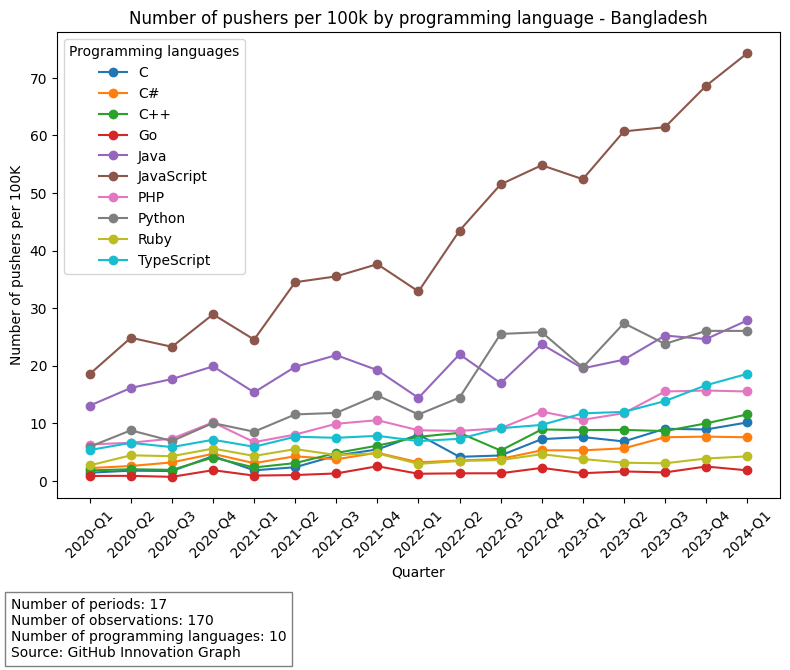

In [126]:
# Crear el gráfico de líneas
plt.figure(figsize=(8, 6))

for language in data_aggregated_LK['language'].unique():
    language_data_LK = data_aggregated_LK[data_aggregated_LK['language'] == language]
    plt.plot(language_data_LK['year_quarter'], language_data_LK['num_pushers_pc'], marker='o', label=language)

# Personalizar el gráfico
plt.title('Number of pushers per 100k by programming language - Bangladesh')
plt.xlabel('Quarter')
plt.ylabel('Number of pushers per 100K')
plt.legend(title='Programming languages')
plt.xticks(rotation=45)

# Crear el texto de las estadísticas
statistics_text = ('Number of periods: 17\n'
                   'Number of observations: 170\n'
                   'Number of programming languages: 10\n'
                   'Source: GitHub Innovation Graph')

# Añadir texto adicional debajo del gráfico
plt.figtext(0.02, -0.1, statistics_text, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

INDIA

In [97]:
df_filtered_IN = balanced_df[balanced_df['iso2_code'] == 'IN']
df_filtered_IN.head()

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter,gpt_available,population,num_pushers_pc
8840,IN,JavaScript,2020-Q1,IN-JavaScript,110247.0,programming,2020,1,1,1263930000,8.722556
8841,IN,JavaScript,2020-Q2,IN-JavaScript,157459.0,programming,2020,2,1,1263930000,12.457889
8842,IN,JavaScript,2020-Q3,IN-JavaScript,184385.0,programming,2020,3,1,1263930000,14.588229
8843,IN,JavaScript,2020-Q4,IN-JavaScript,190204.0,programming,2020,4,1,1263930000,15.048618
8844,IN,JavaScript,2021-Q1,IN-JavaScript,185333.0,programming,2021,5,1,1263930000,14.663233


In [98]:
# Suponiendo que 'data' es tu DataFrame
data_aggregated_IN = df_filtered_IN.groupby('language').size().reset_index(name='counts')
data_aggregated_IN['percentage'] = (data_aggregated_IN['counts'] / data_aggregated_IN['counts'].sum()) * 100

In [99]:
# Convertir 'num_pushers' a numérico si es necesario
df_filtered_IN['num_pushers_pc'] = pd.to_numeric(df_filtered_IN['num_pushers_pc'], errors='coerce')

# Agregar datos por 'year_quarter' y 'language'
data_aggregated_IN = df_filtered_IN.groupby(['year_quarter', 'language'], as_index=False).agg(
    total_pushers=('num_pushers_pc', 'sum')
).rename(columns={'total_pushers': 'num_pushers_pc'})

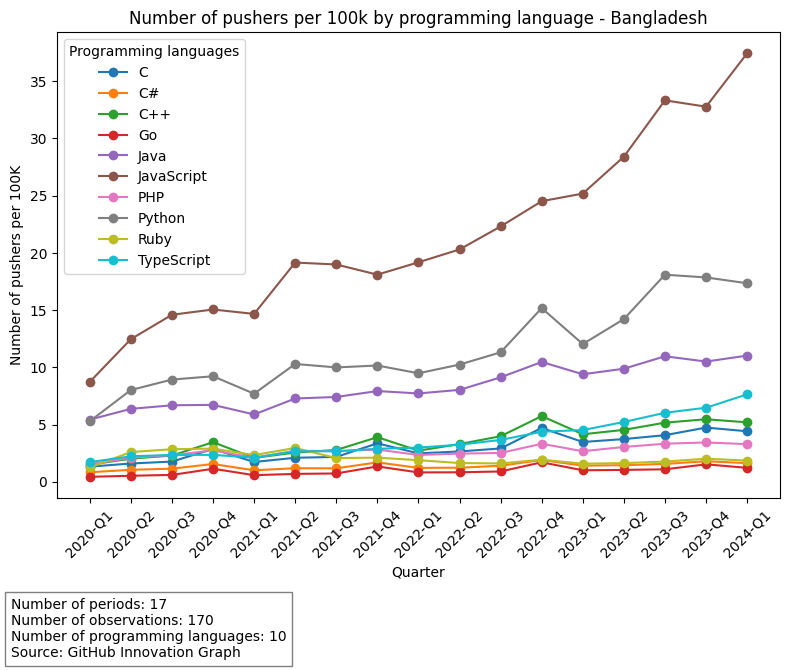

In [125]:
# Crear el gráfico de líneas
plt.figure(figsize=(8, 6))

for language in data_aggregated_IN['language'].unique():
    language_data_IN = data_aggregated_IN[data_aggregated_IN['language'] == language]
    plt.plot(language_data_IN['year_quarter'], language_data_IN['num_pushers_pc'], marker='o', label=language)

# Personalizar el gráfico
plt.title('Number of pushers per 100k by programming language - Bangladesh')
plt.xlabel('Quarter')
plt.ylabel('Number of pushers per 100K')
plt.legend(title='Programming languages')
plt.xticks(rotation=45)

# Crear el texto de las estadísticas
statistics_text = ('Number of periods: 17\n'
                   'Number of observations: 170\n'
                   'Number of programming languages: 10\n'
                   'Source: GitHub Innovation Graph')

# Añadir texto adicional debajo del gráfico
plt.figtext(0.02, -0.1, statistics_text, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# **Figure 2:**  Repositories per 100k

In [101]:
url = "https://raw.githubusercontent.com/github/innovationgraph/main/data/repositories.csv"
repos = pd.read_csv(url, delimiter=',', keep_default_na=False)
repos.head()

,repositories,iso2_code,year,quarter
0,30669781,US,2020,1
1,20179087,CN,2020,1
2,17912888,EU,2020,1
3,9254535,IN,2020,1
4,4171705,GB,2020,1


In [102]:
repos_update = repos[repos['iso2_code'].isin(['BD', 'LK', 'IN'])]
repos_update = repos_update.reset_index(drop=True)
repos_update.head()

,repositories,iso2_code,year,quarter
0,9254535,IN,2020,1
1,588881,BD,2020,1
2,257723,LK,2020,1
3,10503365,IN,2020,2
4,656174,BD,2020,2


In [103]:
# Create population
repos_update["population"] = repos_update["iso2_code"].map(country_populations)

# Create pushes_pc
repos_update["repositories_pc"] = (repos_update["repositories"] / repos_update["population"])*100000

#create year-quarter
repos_update['year_quarter'] = repos_update['year'].astype(str) + '-Q' + repos_update['quarter'].astype(str)


# Mapeo de códigos ISO a nombres de países
country_map = {
    'BD': 'Bangladesh',
    'IN': 'India',
    'LK': 'Sri Lanka'
}

# Crear una nueva columna con los nombres de los países
repos_update['country'] = repos_update['iso2_code'].map(country_map)

repos_update.head()

,repositories,iso2_code,year,quarter,population,repositories_pc,year_quarter,country
0,9254535,IN,2020,1,1263930000,732.203128,2020-Q1,India
1,588881,BD,2020,1,157486000,373.925936,2020-Q1,Bangladesh
2,257723,LK,2020,1,20277597,1270.974071,2020-Q1,Sri Lanka
3,10503365,IN,2020,2,1263930000,831.008442,2020-Q2,India
4,656174,BD,2020,2,157486000,416.655449,2020-Q2,Bangladesh


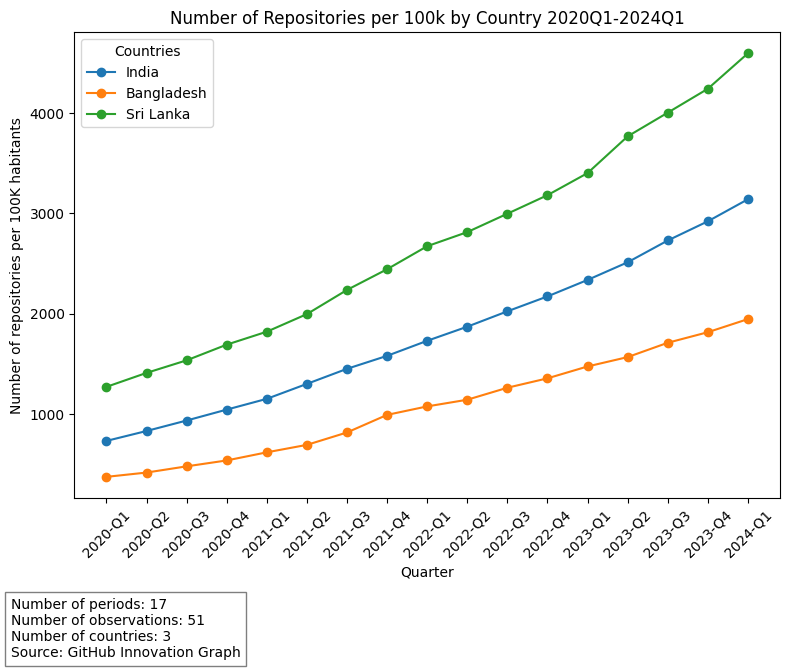

In [124]:
# Crear el gráfico de líneas
plt.figure(figsize=(8, 6))

for country in repos_update['country'].unique():
    country_data_1 = repos_update[repos_update['country'] == country]
    plt.plot(country_data_1['year_quarter'], country_data_1['repositories_pc'], marker='o', label=country)

# Personalizar el gráfico
plt.title('Number of Repositories per 100k by Country 2020Q1-2024Q1')
plt.xlabel('Quarter')
plt.ylabel('Number of repositories per 100K habitants')
plt.legend(title='Countries')
plt.xticks(rotation=45)

# Crear el texto de las estadísticas
statistics_text = ('Number of periods: 17\n'
                   'Number of observations: 51\n'
                   'Number of countries: 3\n'
                   'Source: GitHub Innovation Graph')

# Añadir texto adicional debajo del gráfico
plt.figtext(0.02, -0.1, statistics_text, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()


# **Figure 3:** Developers per 100k

In [105]:
url = "https://raw.githubusercontent.com/github/innovationgraph/main/data/developers.csv"
dev = pd.read_csv(url, delimiter=',', keep_default_na=False)
dev.head()

,developers,iso2_code,year,quarter
0,9763122,US,2020,1
1,6983489,EU,2020,1
2,5885036,CN,2020,1
3,4194257,IN,2020,1
4,1635516,GB,2020,1


In [106]:
dev = dev[dev.iso2_code != "EU"]

In [107]:
dev_update = dev[dev['iso2_code'].isin(['BD', 'LK', 'IN'])]
dev_update = dev_update.reset_index(drop=True)
dev_update.head()

,developers,iso2_code,year,quarter
0,4194257,IN,2020,1
1,215789,BD,2020,1
2,84292,LK,2020,1
3,4684375,IN,2020,2
4,246934,BD,2020,2


In [108]:
# Create population
dev_update["population"] = dev_update["iso2_code"].map(country_populations)

# Create pushes_pc
dev_update["developers_pc"] = (dev_update["developers"] / dev_update["population"])*100000

#create year-quarter
dev_update['year_quarter'] = dev_update['year'].astype(str) + '-Q' + dev_update['quarter'].astype(str)

# Mapeo de códigos ISO a nombres de países
country_map = {
    'BD': 'Bangladesh',
    'IN': 'India',
    'LK': 'Sri Lanka'
}

# Crear una nueva columna con los nombres de los países
dev_update['country'] = dev_update['iso2_code'].map(country_map)

dev_update.head()

,developers,iso2_code,year,quarter,population,developers_pc,year_quarter,country
0,4194257,IN,2020,1,1263930000,331.842507,2020-Q1,India
1,215789,BD,2020,1,157486000,137.021069,2020-Q1,Bangladesh
2,84292,LK,2020,1,20277597,415.690281,2020-Q1,Sri Lanka
3,4684375,IN,2020,2,1263930000,370.619813,2020-Q2,India
4,246934,BD,2020,2,157486000,156.797430,2020-Q2,Bangladesh


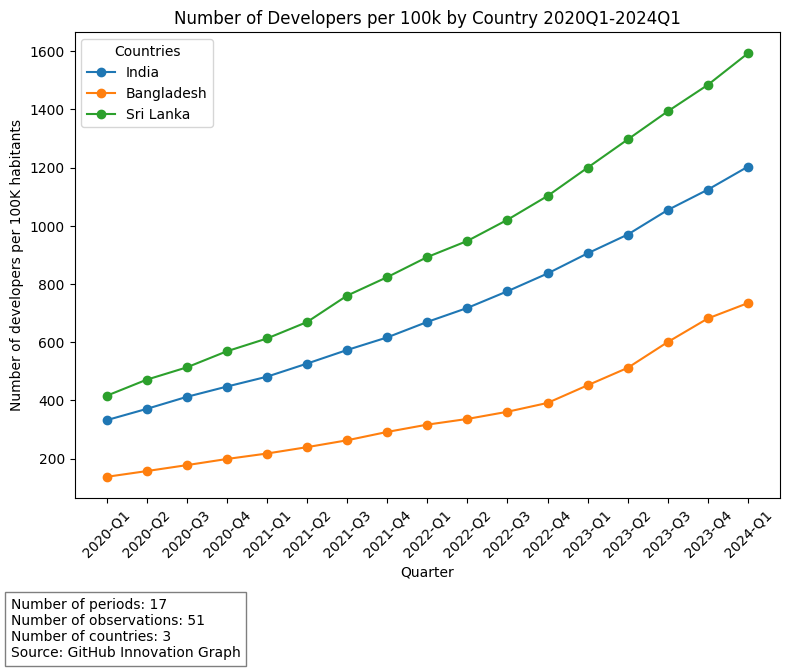

In [123]:
# Crear el gráfico de líneas
plt.figure(figsize=(8, 6))

for country in dev_update['country'].unique():
    country_data_2 = dev_update[dev_update['country'] == country]
    plt.plot(country_data_2['year_quarter'], country_data_2['developers_pc'], marker='o', label=country)

# Personalizar el gráfico
plt.title('Number of Developers per 100k by Country 2020Q1-2024Q1')
plt.xlabel('Quarter')
plt.ylabel('Number of developers per 100K habitants')
plt.legend(title='Countries')
plt.xticks(rotation=45)

# Crear el texto de las estadísticas
statistics_text = ('Number of periods: 17\n'
                   'Number of observations: 51\n'
                   'Number of countries: 3\n'
                   'Source: GitHub Innovation Graph')

# Añadir texto adicional debajo del gráfico
plt.figtext(0.02, -0.1, statistics_text, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()


# **Figure 4:**  Organizations per 100k

In [110]:
url = "https://raw.githubusercontent.com/github/innovationgraph/main/data/organizations.csv"
org = pd.read_csv(url, delimiter=',', keep_default_na=False)
org.head()

,organizations,iso2_code,year,quarter
0,601565,US,2020,1
1,433848,EU,2020,1
2,377119,CN,2020,1
3,247204,IN,2020,1
4,125302,BR,2020,1


In [111]:
org = org[org.iso2_code != "EU"]

In [112]:
org_update = org[org['iso2_code'].isin(['BD', 'LK', 'IN'])]
org_update = org_update.reset_index(drop=True)
org_update.head()

,organizations,iso2_code,year,quarter
0,247204,IN,2020,1
1,26487,BD,2020,1
2,7205,LK,2020,1
3,268762,IN,2020,2
4,27532,BD,2020,2


In [113]:
# Create population
org_update["population"] = org_update["iso2_code"].map(country_populations)

# Create organizations_pc
org_update["organizations_pc"] = (org_update["organizations"] / org_update["population"])*100000

#create year-quarter
org_update['year_quarter'] = org_update['year'].astype(str) + '-Q' + org_update['quarter'].astype(str)

# Mapeo de códigos ISO a nombres de países
country_map = {
    'BD': 'Bangladesh',
    'IN': 'India',
    'LK': 'Sri Lanka'
}

# Crear una nueva columna con los nombres de los países
org_update['country'] = org_update['iso2_code'].map(country_map)

org_update.head()

,organizations,iso2_code,year,quarter,population,organizations_pc,year_quarter,country
0,247204,IN,2020,1,1263930000,19.558362,2020-Q1,India
1,26487,BD,2020,1,157486000,16.818638,2020-Q1,Bangladesh
2,7205,LK,2020,1,20277597,35.531824,2020-Q1,Sri Lanka
3,268762,IN,2020,2,1263930000,21.263994,2020-Q2,India
4,27532,BD,2020,2,157486000,17.482189,2020-Q2,Bangladesh


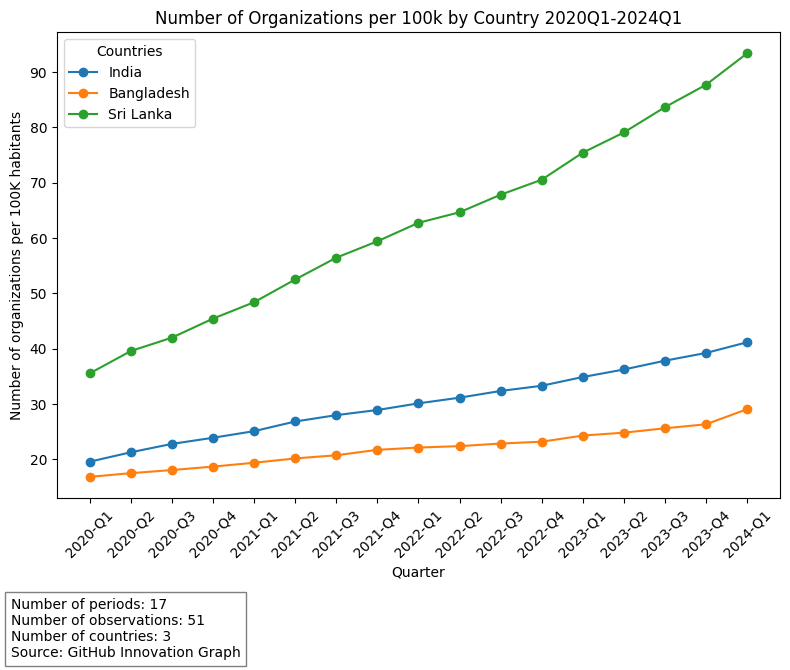

In [122]:
# Crear el gráfico de líneas
plt.figure(figsize=(8, 6))

for country in org_update['country'].unique():
    country_data_3 = org_update[org_update['country'] == country]
    plt.plot(country_data_3['year_quarter'], country_data_3['organizations_pc'], marker='o', label=country)

# Personalizar el gráfico
plt.title('Number of Organizations per 100k by Country 2020Q1-2024Q1')
plt.xlabel('Quarter')
plt.ylabel('Number of organizations per 100K habitants')
plt.legend(title='Countries')
plt.xticks(rotation=45)

# Crear el texto de las estadísticas
statistics_text = ('Number of periods: 17\n'
                   'Number of observations: 51\n'
                   'Number of countries: 3\n'
                   'Source: GitHub Innovation Graph')

# Añadir texto adicional debajo del gráfico
plt.figtext(0.02, -0.1, statistics_text, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()


# **Figura 5:**  Pushes per 100k

In [115]:
url = "https://raw.githubusercontent.com/github/innovationgraph/main/data/git_pushes.csv"
pushes = pd.read_csv(url, delimiter=',', keep_default_na=False)
pushes.head()

,git_pushes,iso2_code,year,quarter
0,21377653,US,2020,1
1,17175696,EU,2020,1
2,5567938,CN,2020,1
3,4422587,IN,2020,1
4,3980488,GB,2020,1


In [116]:
pushes = pushes[pushes.iso2_code != "EU"]

In [117]:
git_update = pushes[pushes['iso2_code'].isin(['BD', 'LK', 'IN'])]
git_update = git_update.reset_index(drop=True)
git_update.head()

,git_pushes,iso2_code,year,quarter
0,4422587,IN,2020,1
1,295222,BD,2020,1
2,144885,LK,2020,1
3,7346825,IN,2020,2
4,390126,BD,2020,2


In [118]:
# Create population
git_update["population"] = git_update["iso2_code"].map(country_populations)

# Create organizations_pc
git_update["git_pushes_pc"] = (git_update["git_pushes"] / git_update["population"])*100000

#create year-quarter
git_update['year_quarter'] = git_update['year'].astype(str) + '-Q' + git_update['quarter'].astype(str)

# Mapeo de códigos ISO a nombres de países
country_map = {
    'BD': 'Bangladesh',
    'IN': 'India',
    'LK': 'Sri Lanka'
}

# Crear una nueva columna con los nombres de los países
git_update['country'] = git_update['iso2_code'].map(country_map)


git_update.head()

,git_pushes,iso2_code,year,quarter,population,git_pushes_pc,year_quarter,country
0,4422587,IN,2020,1,1263930000,349.907590,2020-Q1,India
1,295222,BD,2020,1,157486000,187.459203,2020-Q1,Bangladesh
2,144885,LK,2020,1,20277597,714.507740,2020-Q1,Sri Lanka
3,7346825,IN,2020,2,1263930000,581.268346,2020-Q2,India
4,390126,BD,2020,2,157486000,247.721067,2020-Q2,Bangladesh


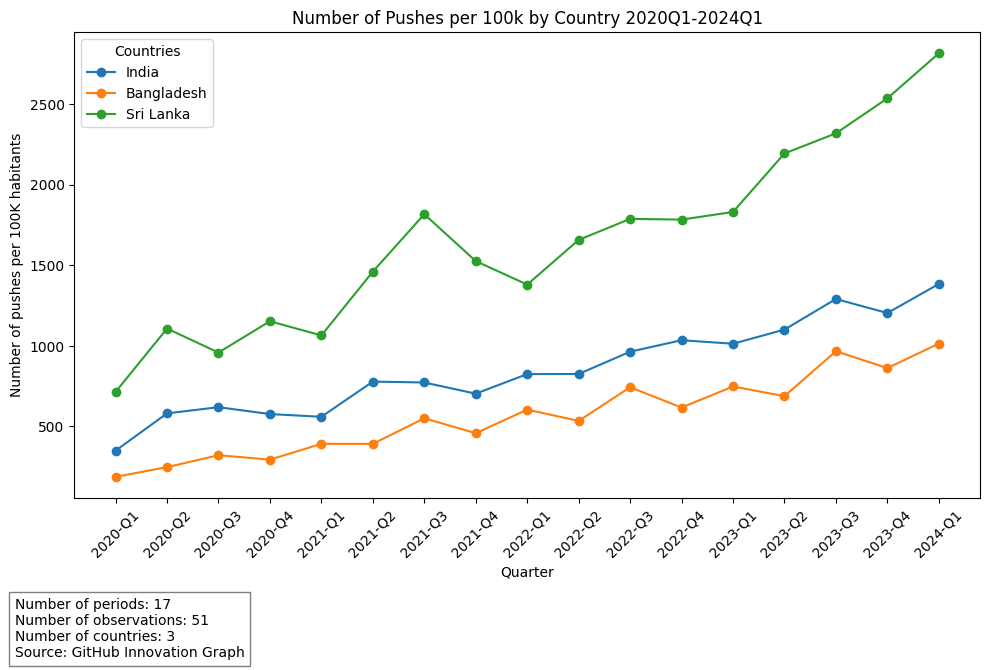

In [119]:
# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

for country in git_update['country'].unique():
    country_data_4 = git_update[git_update['country'] == country]
    plt.plot(country_data_4['year_quarter'], country_data_4['git_pushes_pc'], marker='o', label=country)

# Personalizar el gráfico
plt.title('Number of Pushes per 100k by Country 2020Q1-2024Q1')
plt.xlabel('Quarter')
plt.ylabel('Number of pushes per 100K habitants')
plt.legend(title='Countries')
plt.xticks(rotation=45)

# Crear el texto de las estadísticas
statistics_text = ('Number of periods: 17\n'
                   'Number of observations: 51\n'
                   'Number of countries: 3\n'
                   'Source: GitHub Innovation Graph')

# Añadir texto adicional debajo del gráfico
plt.figtext(0.02, -0.1, statistics_text, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()